<a href="https://colab.research.google.com/github/davidespada99/SecureNumPad/blob/main/CNSDataHandlers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Get data from CSVs

In [ ]:
Users =  pd.read_csv("User.csv", index_col="ID")
Registrations = pd.read_csv("Registration.csv")
Logins = pd.read_csv("Login.csv")

In [ ]:
Users.head()

,PIN
ID,
1,9715
2,7672
3,6881
4,5439
5,2358


In [ ]:
Users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 1 to 25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0    PIN    25 non-null     int64
dtypes: int64(1)
memory usage: 400.0 bytes


In [ ]:
Registrations.head()

,ID,attempt,buttonID,getSize
0,1,1,9,2.158730
1,1,1,7,2.357143
2,1,1,1,2.468254
3,1,1,5,2.301587
4,1,2,9,1.730159


In [ ]:
Logins.head()

,ID,userPINID,attempt,buttonID,getSize
0,1,1,1,9,2.309524
1,1,1,1,7,2.333333
2,1,1,1,1,2.801588
3,1,1,1,5,2.015873
4,1,1,2,9,2.071429


## Normalization / Standardization

In [ ]:
def normalize():
  Registrations.iloc[:, 3] = (Registrations.iloc[:, 3] - Registrations.iloc[:, 3].min() ) / ( Registrations.iloc[:, 3].max() - Registrations.iloc[:, 3].min() )
  Logins.iloc[:, 4] = (Logins.iloc[:, 4] - Logins.iloc[:, 4].min() ) / ( Logins.iloc[:, 4].max() - Logins.iloc[:, 4].min() )

# New Section

In [ ]:
def standardize():
  Registrations.iloc[:, 3] = (Registrations.iloc[:, 3] - Registrations.iloc[:, 3].mean() ) / ( Registrations.iloc[:, 3].std())
  Logins.iloc[:, 4] = (Logins.iloc[:, 4] - Logins.iloc[:, 4].mean() ) / ( Logins.iloc[:, 4].std() )

In [ ]:
#normalize()
standardize()

In [ ]:
Logins.describe(), Registrations.describe()

(                 ID     userPINID       attempt      buttonID       getSize
 count  10428.000000  10428.000000  10428.000000  10428.000000  1.042800e+04
 mean      13.125048     12.763713      2.498657      4.673092  7.304390e-16
 std        7.208182      7.198202      1.118258      2.732865  1.000000e+00
 min        1.000000      1.000000      1.000000      0.000000 -3.705362e+00
 25%        7.000000      7.000000      1.000000      2.000000 -6.952787e-01
 50%       13.000000     13.000000      2.000000      5.000000 -6.680010e-02
 75%       20.000000     19.000000      3.000000      7.000000  6.278350e-01
 max       25.000000     25.000000      4.000000      9.000000  4.630255e+00,
                 ID      attempt     buttonID       getSize
 count  1000.000000  1000.000000  1000.000000  1.000000e+03
 mean     13.000000     5.500000     4.670000 -9.166001e-16
 std       7.214711     2.873719     2.736529  1.000000e+00
 min       1.000000     1.000000     0.000000 -2.616841e+00
 25%  

# Let's calculate the mean and variance for every user for the entire PIN insertion and for each sample

In [ ]:
samples = [1,2,5,9]
sample_size = 4
IDs = list(set(Logins["ID"]))

# Get data from Register and Login

In [ ]:
def getMeanVarFromRegistrations(ID, samples = [1, 2, 5, 10], sample_size=4):
  means = []
  vars = []
  filtered_Registrations_by_ID = Registrations[Registrations["ID"] == ID]
  for sample in samples:
    filtered_Registrations_by_ID_samples = filtered_Registrations_by_ID[" getSize"].iloc[:sample_size*sample]
    means.append(filtered_Registrations_by_ID_samples.mean())
    vars.append(filtered_Registrations_by_ID_samples.var())
  return np.array(means), np.array(vars)

In [ ]:
def getMeanVarFromLogins(ID):
  means = []
  vars = []
  logins_2 = Logins[Logins["ID"] == ID] # 320 input dell utente ID
  for i in range(1,max(IDs)+ 1): #per ogni user dell utente ID...
    means.append(logins_2[logins_2[" userPINID"] == i][" getSize"].mean()) # fa la media a blocchi di 16, cioè per ogni altro utente
    vars.append(logins_2[logins_2[" userPINID"] == i][" getSize"].var()) # fa la varianza a blocchi di 16, cioè per ogni altro utente
  return np.array(means), np.array(vars)

# Draw the distributions (useless maybe)

In [ ]:
def normal_distribution(x, mean, var):
  constant_term = 1 / (np.sqrt(2 * np.pi * var))
  exponent_term = np.exp(-((x - mean) ** 2) / (2 * var))
  return constant_term * exponent_term

In [ ]:
def drawDistributions(means, vars):
  x = np.linspace(means.mean()-10*means.std(), means.mean()+10*means.std(),1000)
  for mean, var in zip(means, vars):
    plt.plot(x, normal_distribution(x, mean, var))

  plt.show()

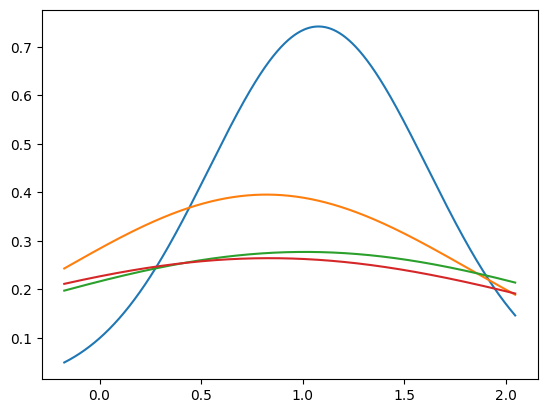

In [ ]:
regMeans, regVars = getMeanVarFromRegistrations(1, samples)
logMeans, logVars = getMeanVarFromLogins(1)
drawDistributions(regMeans, regVars)

# HelperFunctions

##isLoginPermitted


In [ ]:
def isLoginPermitted(regMean, regVar, logMean, error):
  return regMean-regVar*error <= logMean <= regMean+regVar*error

## Metrics

In [ ]:
def Recall(CM):
  if( (CM[0] == 0) and (CM[2] == 0)): return 0
  return CM[0] / (CM[0] + CM[2])

In [ ]:
def Precision(CM):
  if( (CM[0] == 0) and (CM[1] == 0)): return 0
  return CM[0] / (CM[0] + CM[1])

In [ ]:
def Accuracy(CM):
  if ( CM[0] + CM[1] + CM[2] + CM[3] ) == 0: return 0
  return (CM[0] + CM[3])/(CM[0] + CM[1] + CM[2] + CM[3])

In [ ]:
def F1Score(CM):
  precision = Precision(CM)
  recall = Recall(CM)
  if( precision == 0 and recall == 0): return 0
  return 2 * (precision * recall) / ( precision + recall)

In [ ]:
def MDRate(CM):
  if( CM[0] == 0 and CM[2] == 0): return 0
  return ((CM[2])/(CM[0] + CM[2]))  # FN / (TP + FN)

In [ ]:
def FARate(CM):
  if( CM[0] == 0 and CM[1] == 0): return 0
  return ((CM[1])/(CM[3] + CM[1]))  # FP / (TN + FP)

In [ ]:
getMeanVarFromRegistrations(1, [1,2,5,10])

(array([1.0779515 , 0.82113866, 1.01167742, 0.84682003]),
 array([0.28879271, 1.01704921, 2.06917066, 2.21410506]))

# Simulation per PIN

## Simulation NEW

In [ ]:
def RunSimulation(n_user = 25):
  errors = [0.05, 0.2, 0.25, 0.3, 0.35, 0.5, 1, 2, 5, 10]
  batches = [1,2,5,10]
  CMs = []
  headers = ["Batch", "Error", "Accuracy", "Precision", "Recall", "F1Score", "MDR", "FAR"]
  df = pd.DataFrame(columns=headers, index=None)

  for e in errors: # 4
    for batch in batches: #4
      CM = np.zeros(4)

      # ========== Compute Confusion matrix ============= #
      for userIndex in range(1, n_user+1):
        regMean, regVar = getMeanVarFromRegistrations(userIndex, [batch]) # 1
        logMeans, logVars = getMeanVarFromLogins(userIndex) # n_user
        for otherUserIndex, logMean in enumerate(logMeans):
          isPermitted = isLoginPermitted(regMean, regVar, logMean, e)
          if (isPermitted):
            if (userIndex == otherUserIndex):
              CM[0]+=24 #TP
            else:
                CM[1]+=1 #FP
          else:
            if (userIndex != otherUserIndex):
              CM[3]+=1 #TN
            else:
              CM[2]+=24 #FN
      accuracy = Accuracy(CM)
      precision = Precision(CM)
      recall = Recall(CM)
      f1score = F1Score(CM)
      missed_detection = MDRate(CM)
      false_acceptance = FARate(CM)
      print(f"[{e}][{batch}]",  CM, missed_detection)
      new_row = {
        "Batch": batch,
        "Error": e,
        "Accuracy": round(accuracy, 2),
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1Score": round(f1score, 2),
        "MDR" : round(missed_detection, 2),
        "FAR" : round(false_acceptance, 2),
      }
      df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

          #print(f"=== User {userIndex+1} Sample: {batches[sampleIndex]} Error: {e*100}% = A: {(accuracy * 100):.2f}% = P: {(precision * 100):.2f}% = R: {(recall * 100):.2f}% = F1: {(f1score * 100):.2f}% = ")
  return df


In [ ]:
sim1df = RunSimulation(25)

[0.05][1] [  0.  29. 576. 572.] 1.0
[0.05][2] [  0.  33. 576. 568.] 1.0
[0.05][5] [ 24.  37. 552. 564.] 0.9583333333333334
[0.05][10] [ 24.  37. 552. 564.] 0.9583333333333334
[0.2][1] [ 72. 105. 504. 496.] 0.875
[0.2][2] [ 96. 112. 480. 489.] 0.8333333333333334
[0.2][5] [ 48. 127. 528. 474.] 0.9166666666666666
[0.2][10] [ 96. 132. 480. 469.] 0.8333333333333334
[0.25][1] [ 96. 130. 480. 471.] 0.8333333333333334
[0.25][2] [120. 145. 456. 456.] 0.7916666666666666
[0.25][5] [ 48. 161. 528. 440.] 0.9166666666666666
[0.25][10] [120. 160. 456. 441.] 0.7916666666666666
[0.3][1] [ 96. 156. 480. 445.] 0.8333333333333334
[0.3][2] [120. 166. 456. 435.] 0.7916666666666666
[0.3][5] [ 72. 187. 504. 414.] 0.875
[0.3][10] [144. 193. 432. 408.] 0.75
[0.35][1] [120. 182. 456. 419.] 0.7916666666666666
[0.35][2] [168. 202. 408. 399.] 0.7083333333333334
[0.35][5] [120. 218. 456. 383.] 0.7916666666666666
[0.35][10] [144. 221. 432. 380.] 0.75
[0.5][1] [216. 246. 360. 355.] 0.625
[0.5][2] [240. 270. 336. 331.]

In [ ]:
sim1df

,Batch,Error,Accuracy,Precision,Recall,F1Score,MDR,FAR
0,1,0.05,0.49,0.00,0.00,0,1.00,0.05
1,2,0.05,0.48,0.00,0.00,0,1.00,0.05
2,5,0.05,0.50,0.39,0.04,0.08,0.96,0.06
3,10,0.05,0.50,0.39,0.04,0.08,0.96,0.06
4,1,0.20,0.48,0.41,0.12,0.19,0.88,0.17
5,2,0.20,0.50,0.46,0.17,0.24,0.83,0.19
6,5,0.20,0.44,0.27,0.08,0.13,0.92,0.21
7,10,0.20,0.48,0.42,0.17,0.24,0.83,0.22
8,1,0.25,0.48,0.42,0.17,0.24,0.83,0.22
9,2,0.25,0.49,0.45,0.21,0.29,0.79,0.24


## Charts


## Chart to compare various users distributions

In [ ]:
def drawDistributionsForUser(users):
  means = []
  vars = []

  for user in users:
    regMean, regVar = getMeanVarFromRegistrations(user, [10])
    means.append(regMean)
    vars.append(regVar)
  means = np.array(means)
  vars = np.array(vars)
  x = np.linspace(means.mean()-6*means.std(), means.mean()+6*means.std(),1000)
  for i, (mean, var) in enumerate(zip(means, vars)):
    plt.plot(x, normal_distribution(x, mean, var), label=f"User {users[i]}")

  plt.title("Users distributions (PIN Based)")
  plt.legend()
  plt.grid()
  plt.show()

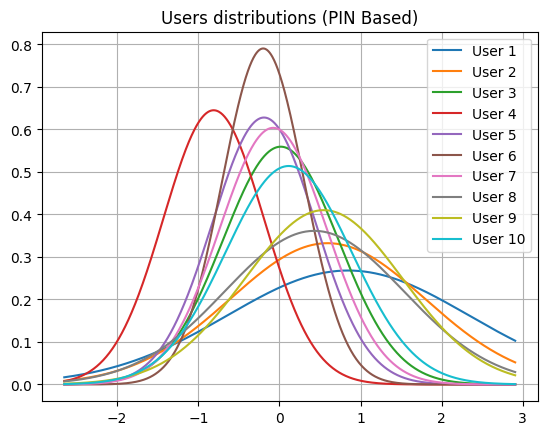

In [ ]:
users = [1,2,3,4,5,6,7,8,9,10]
drawDistributionsForUser(users)

## Chart for showing simulations results


In [ ]:

def drawChartsPINBased(errors, batches, metrics_to_filt, df):
    # Metrics to plot
    metrics = [col for col in metrics_to_filt if col in df.columns]
    colors = ["red", "blue", "green", "purple", "orange", "brown", "pink"]

    fig, axs = plt.subplots(int(np.ceil(len(errors)/2)), 2, figsize=(15, 10))
    axs = axs.flatten()

    for i, error in enumerate(errors):
        ax = axs[i]
        tmp_df = df[df["Error"] == error]

        for j, metric in enumerate(metrics):
            sns.lineplot(data=tmp_df, x='Batch', y=metric, marker='o', ax=ax, color=colors[j % len(colors)], label=metric, alpha=0.6)

        ax.set_title(f'Error = {error}')
        ax.set_xlabel('Batch')
        ax.set_ylabel('Metrics')
        ax.set_ylim(-0.1, 1.1)
        ax.legend()

        # Adding grid with alignment to data points
        ax.set_xticks(batches)  # Set x-ticks to align with Batch data points
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

    plt.tight_layout()
    plt.show()

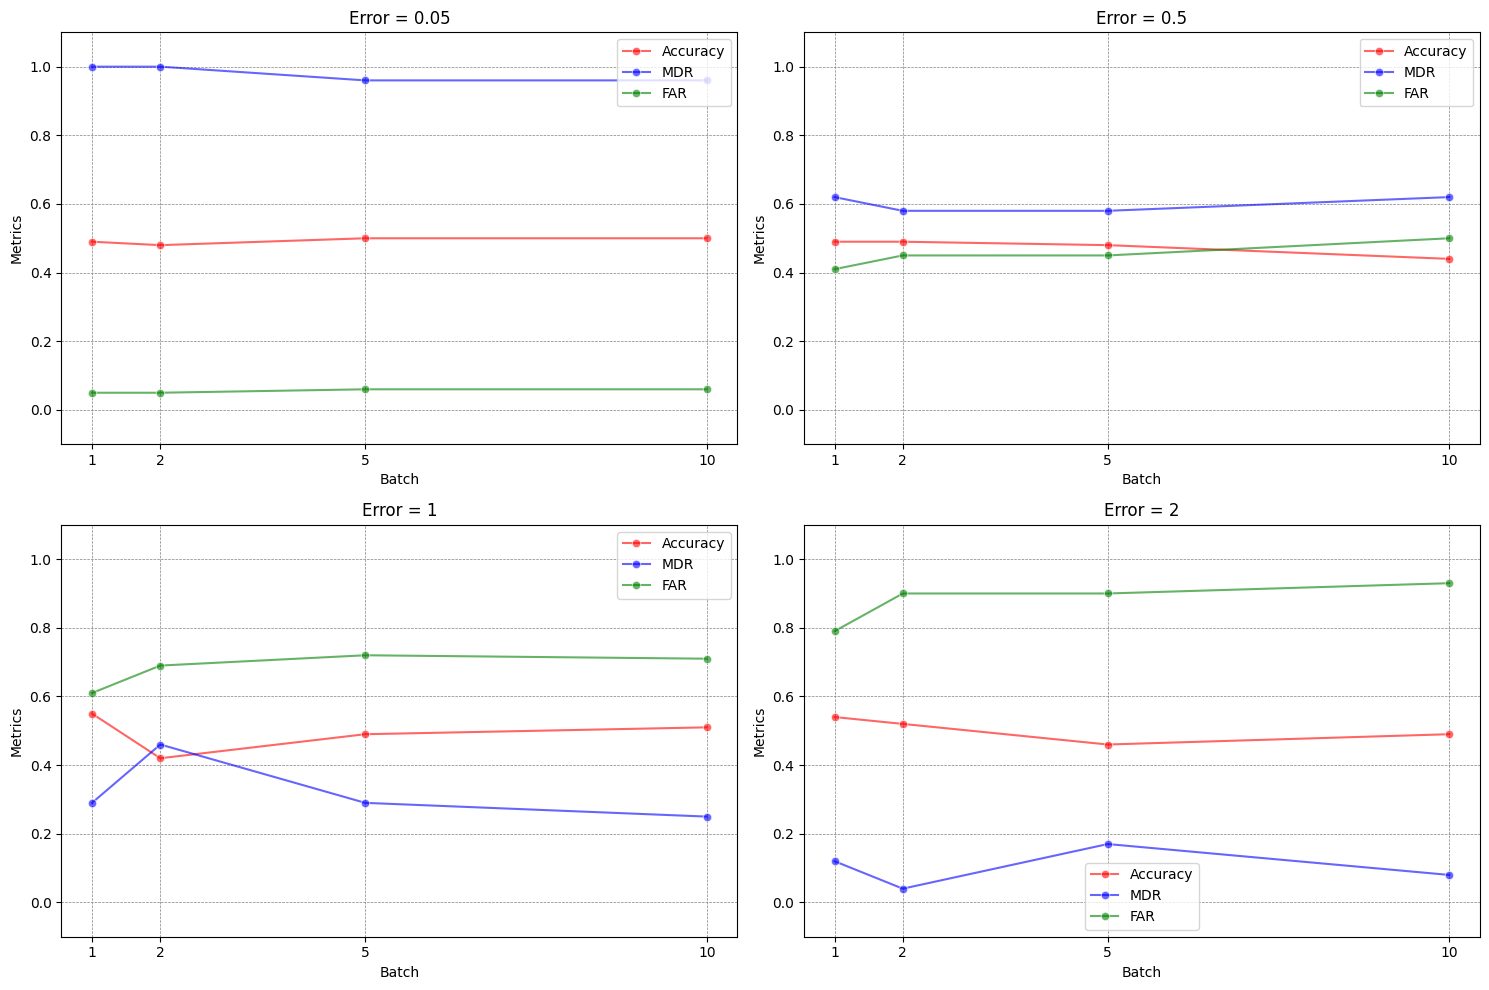

In [ ]:
drawChartsPINBased([0.05, 0.5, 1, 2], [1, 2, 5,10], ['Accuracy', 'MDR', 'FAR'], sim1df)

## Simulation OLD

In [ ]:
import time
def RunSimulation1(n_user = 25):

  delta = 0

  batches = [1,2,5,10]
  CMs = []

  delta = 0
  precision = 0

  while( delta < 5):
    CM = np.zeros(4)

    for userIndex in range(n_user):
      regMeans, regVars = getMeanVarFromRegistrations(userIndex+1, samples)
      logMeans, logVars = getMeanVarFromLogins(userIndex+1)
      #for sampleIndex ,(regMean, regVar) in enumerate(zip(regMeans, regVars)):
      for otherUserIndex, (logMean, logVar) in enumerate(zip(logMeans, logVars)):
        isPermitted = isLoginPermitted(regMeans[3], regVars[3], logMean, delta)
        if (isPermitted):
          if (userIndex == otherUserIndex):
            CM[0]+=1
          else:
              CM[1]+=1
        else:
          if (userIndex != otherUserIndex):
            CM[3]+=1
          else:
            CM[2]+=1
    accuracy = Accuracy(CM)
    precision = Precision(CM)
    recall = Recall(CM)
    f1score = F1Score(CM)



    print(f"= DELTA [{delta:.2f}] A: {(accuracy * 100):.2f}% = P: {(precision * 100):.2f}% = R: {(recall * 100):.2f}% = F1: {(f1score * 100):.2f}% = ")
    print(CM)
    time.sleep(0.1)
    delta+=0.05



In [ ]:
#RunSimulation1()

# Simulation per DIGIT


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def getMeanVarFromRegistrationsForButton(ID, batches = [1,2,5,10], batch_size=4 ):
  means = {}
  vars = {}
  filtered_Registrations_by_ID = Registrations[Registrations["ID"] == ID]
  for key in range(9):
    filtered_Registrations_by_Key = filtered_Registrations_by_ID[Registrations[" buttonID"] == key]
    if(filtered_Registrations_by_Key.empty): continue
    for batch in batches:
      filtered_Registrations_by_ID_key_samples = filtered_Registrations_by_Key[" getSize"].iloc[:sample_size*batch]
      means[key] = (filtered_Registrations_by_ID_key_samples.mean())
      vars[key] = (filtered_Registrations_by_ID_key_samples.var())

  return means, vars

In [ ]:
getMeanVarFromRegistrationsForButton(1, [10], 4),getMeanVarFromRegistrationsForButton(2, [10], 4),getMeanVarFromRegistrationsForButton(3, [10], 4)

(({1: 2.638711830463131, 5: 0.614031507212741, 7: 0.8592464161782137},
  {1: 1.8936119732928576, 5: 0.5146902522386716, 7: 0.537432528478526}),
 ({2: 1.3364214225930922, 6: -0.7015136126268957, 7: 0.8708445255744767},
  {2: 2.135394764777281, 6: 0.21248891646858525, 7: 0.5902855211175418}),
 ({1: 0.7068155860110912, 6: -0.1680053586293225, 8: -0.23759326840838044},
  {1: 0.7220548029103205, 6: 0.10040032905153604, 8: 0.317585343361894}))

In [ ]:
def getMeanVarFromLoginsForButton(ID, forWho):
  means = {}
  vars = {}
  filtered_Logins_by_ID = Logins[Logins["ID"] == ID]
  filtered_Logins_by_ID = filtered_Logins_by_ID[Logins[" userPINID"] == forWho]
  for key in range(10):
    filtered_Logins_by_Key = filtered_Logins_by_ID[Logins[" buttonID"] == key]
    if(filtered_Logins_by_Key.empty): continue
    filtered_Logins_by_ID_key_samples = filtered_Logins_by_Key[" getSize"]
    means[key] = (filtered_Logins_by_ID_key_samples.mean())
    vars[key] = (filtered_Logins_by_ID_key_samples.var())

  return means, vars

In [ ]:
getMeanVarFromRegistrationsForButton(1)

({1: 2.638711830463131, 5: 0.614031507212741, 7: 0.8592464161782137},
 {1: 1.8936119732928576, 5: 0.5146902522386716, 7: 0.537432528478526})

In [ ]:
getMeanVarFromLoginsForButton(1,1), getMeanVarFromLoginsForButton(2,1), getMeanVarFromLoginsForButton(3,1)

(({1: 2.1080688035136985,
   5: 1.1736197919670501,
   7: 1.0082305808875387,
   9: 0.14820643485334084},
  {1: 1.3599300063294286,
   5: 0.7779360964564166,
   7: 0.8071138465026003,
   9: 1.103991691716679}),
 ({1: 0.39629018936742444,
   5: -0.19911097051881785,
   7: 0.4624459980095973,
   9: -0.8358596505430822},
  {1: 0.11452031894256227,
   5: 0.05762498084368357,
   7: 0.7184876442157401,
   9: 0.186277967314726}),
 ({1: 0.9089968058190949,
   5: 0.6774519103077785,
   7: 1.1488112550421627,
   9: -0.3975781480246004},
  {1: 0.08060182484096279,
   5: 1.050743011548052,
   7: 0.5415098746070349,
   9: 0.2647827458153183}))

In [ ]:
def isLoginPermittedKey(regMeans, regVars, logMeans, delta):
  valid = True

  tot_valid = 0

  """
  for key in regMeans.keys():
      if( not (regMeans[key]-regVars[key]*delta <= logMeans[key] <= regMeans[key]+regVars[key]*delta)):
        valid = False
        break
  """
  for key in regMeans.keys():
      if( (regMeans[key]-regVars[key]*delta <= logMeans[key] <= regMeans[key]+regVars[key]*delta)):
        tot_valid +=1

  return tot_valid >= 3

## RunFindDeltaSimulationPerDIGIT

In [ ]:
def RunFindDeltaSimulationPerDIGIT(d=0.01, n_user = 25):
  errors = [0.01, 0.05, 0.1, 0.2, 0.5]
  CMs = []
  headers = ["Error", "Accuracy", "Precision", "Recall", "F1Score", "MDR", "FAR"]
  df = pd.DataFrame(columns=headers, index=None)
  delta = 0
  while delta <= 10: # 4
    CM = np.zeros(4)

    # ========== Compute Confusion matrix ============= #
    for userIndex in range(1, n_user+1):

      for otherUserIndex in range(1, n_user+1):

        regMeans, regVars = getMeanVarFromRegistrationsForButton(userIndex, [10])
        logMeans, logVars = getMeanVarFromLoginsForButton(otherUserIndex, userIndex)


        isPermitted = isLoginPermittedKey(regMeans, regVars, logMeans, delta)
        if (isPermitted):
          if (userIndex == otherUserIndex):
            CM[0]+=25 #TP
          else:
              CM[1]+=1 #FP
        else:
          if (userIndex != otherUserIndex):
            CM[3]+=1 #TN
          else:
            CM[2]+=25 #FN
    accuracy = Accuracy(CM)
    precision = Precision(CM)
    recall = Recall(CM)
    f1score = F1Score(CM)
    missed_detection = MDRate(CM)
    false_acceptance = FARate(CM)
    print(f"[{delta}] ",  CM, missed_detection)
    new_row = {
      "Error": delta,
      "Accuracy": round(accuracy, 2),
      "Precision": round(precision, 2),
      "Recall": round(recall, 2),
      "F1Score": round(f1score, 2),
      "MDR" : round(missed_detection, 2),
      "FAR" : round(false_acceptance, 2),
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    delta+=d
          #print(f"=== User {userIndex+1} Sample: {batches[sampleIndex]} Error: {e*100}% = A: {(accuracy * 100):.2f}% = P: {(precision * 100):.2f}% = R: {(recall * 100):.2f}% = F1: {(f1score * 100):.2f}% = ")
  return df

In [ ]:
#results = RunFindDeltaSimulationPerDIGIT(0.1)

In [ ]:
def RunSimulationPerDIGIT(n_user = 25):
  errors = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
  CMs = []
  headers = ["Error", "Accuracy", "Precision", "Recall", "F1Score", "MDR", "FAR"]
  df = pd.DataFrame(columns=headers, index=None)

  for e in errors: # 4
    CM = np.zeros(4)

    # ========== Compute Confusion matrix ============= #
    for userIndex in range(1, n_user+1):

      for otherUserIndex in range(1, n_user+1):

        regMeans, regVars = getMeanVarFromRegistrationsForButton(userIndex, [10])
        logMeans, logVars = getMeanVarFromLoginsForButton(otherUserIndex, userIndex)


        isPermitted = isLoginPermittedKey(regMeans, regVars, logMeans, e)
        if (isPermitted):
          if (userIndex == otherUserIndex):
            CM[0]+=24 #TP
          else:
              CM[1]+=1 #FP
        else:
          if (userIndex != otherUserIndex):
            CM[3]+=1 #TN
          else:
            CM[2]+=24 #FN
    accuracy = Accuracy(CM)
    precision = Precision(CM)
    recall = Recall(CM)
    f1score = F1Score(CM)
    missed_detection = MDRate(CM)
    false_acceptance = FARate(CM)
    print(f"[{e}] ",  CM, missed_detection)
    new_row = {
      "Error": e,
      "Accuracy": round(accuracy, 2),
      "Precision": round(precision, 2),
      "Recall": round(recall, 2),
      "F1Score": round(f1score, 2),
      "MDR" : round(missed_detection, 2),
      "FAR" : round(false_acceptance, 2),
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

          #print(f"=== User {userIndex+1} Sample: {batches[sampleIndex]} Error: {e*100}% = A: {(accuracy * 100):.2f}% = P: {(precision * 100):.2f}% = R: {(recall * 100):.2f}% = F1: {(f1score * 100):.2f}% = ")
  return df

In [ ]:
df = RunSimulationPerDIGIT()

[0.01]  [  0.   0. 600. 600.] 1.0
[0.05]  [  0.   0. 600. 600.] 1.0
[0.1]  [  0.   0. 600. 600.] 1.0
[0.2]  [  0.   0. 600. 600.] 1.0
[0.5]  [ 24.   5. 576. 595.] 0.96
[1]  [120.  47. 480. 553.] 0.8
[2]  [288. 158. 312. 442.] 0.52
[5]  [432. 366. 168. 234.] 0.28
[10]  [480. 463. 120. 137.] 0.2


In [ ]:
df

,Error,Accuracy,Precision,Recall,F1Score,MDR,FAR
0,0.01,0.50,0,0.00,0,1.00,0
1,0.05,0.50,0,0.00,0,1.00,0
2,0.10,0.50,0,0.00,0,1.00,0
3,0.20,0.50,0,0.00,0,1.00,0
4,0.50,0.52,0.83,0.04,0.08,0.96,0.01
5,1.00,0.56,0.72,0.20,0.31,0.80,0.08
6,2.00,0.61,0.65,0.48,0.55,0.52,0.26
7,5.00,0.56,0.54,0.72,0.62,0.28,0.61
8,10.00,0.51,0.51,0.80,0.62,0.20,0.77


# Charts

First chart is the comparison between users single-digits distribution

In [ ]:
def singleDigitDistrPlot(users, userPINId):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for plotting
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (5, 5))]  # Define a list of line styles

    plt.figure(figsize=(8, 6))  # Create a new figure

    for i, user in enumerate(users):
        means, vars = getMeanVarFromLoginsForButton(user, userPINId)
        means_list = list(means.values())
        vars_list = list(vars.values())

        # X values
        x = np.linspace(min(means_list) - 10 * max(vars_list), max(means_list) + 10 * max(vars_list), 200)


        #y = normal_distribution(x, means.values(), vars.values())


        # Compute Gaussian probability density function for each mean and variance

        for key, color in zip(means.keys(), colors):
            y = 1 / np.sqrt(2 * np.pi * vars[key]) * np.exp(-0.5 * ((x - means[key]) / np.sqrt(vars[key]))**2)

            # Plot the Gaussian distribution with different line styles for each user
            linestyle = linestyles[i % len(linestyles)]
            plt.plot(x, y, label=f'User {user}, Button {key}', color=color, linestyle=linestyle)


        plt.plot(x,y)

    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.title('Standardize users digits distribution (DIGIT based)')
    plt.legend()
    plt.grid(True)
    plt.show()

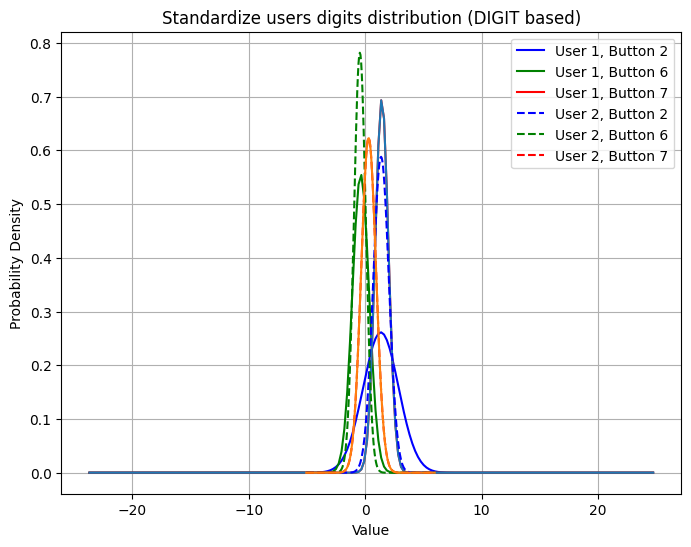

In [ ]:
singleDigitDistrPlot([1,2], 2)

In [ ]:
def drawChartsDIGITBased(errors, metrics_to_filt, df):
    # Metrics to plot
    metrics = [col for col in metrics_to_filt if col in df.columns]
    colors = ["red", "blue", "green", "purple", "orange", "brown", "pink"]
    lineStyles = ['-', '--', '-.', ':', '-', '--', '-.']

    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        color = colors[i % len(metrics)]
        values = []
        for error in errors:
            tmp_df = df[df["Error"] == error]
            values.append(tmp_df[metric].values[0])  # Assuming each error-metric combination has one value

        plt.plot(errors, values, marker='D', color=color, label=f'{metric}')

    plt.xlabel('Error')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

    plt.ylim(-0.1, 1.1)
    plt.xticks(errors)
    plt.yticks()

    plt.show()

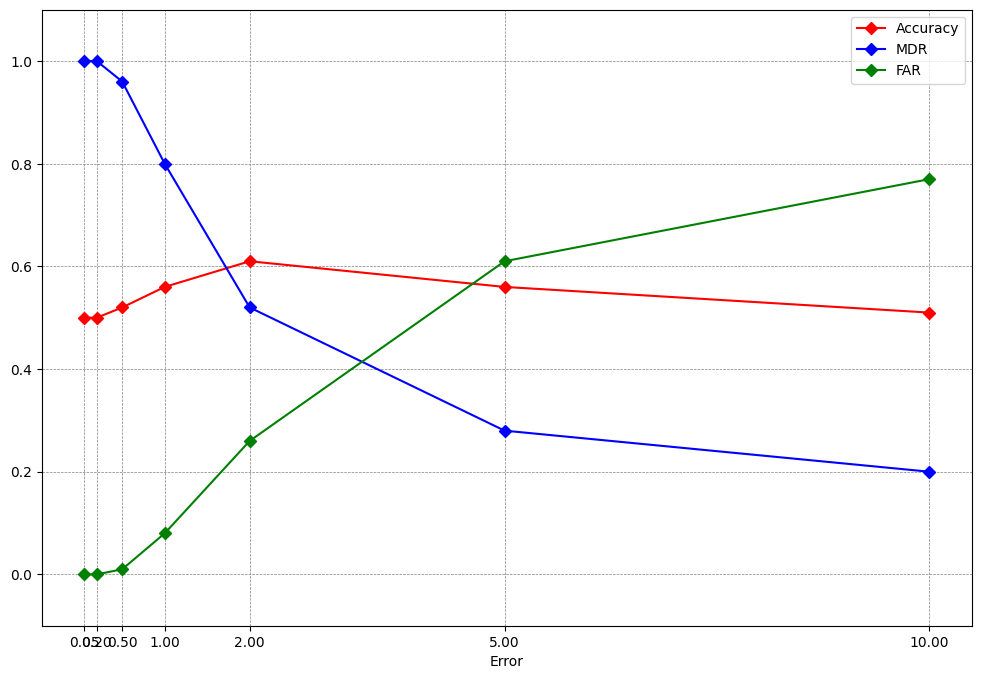

In [ ]:
drawChartsDIGITBased([0.05, 0.2, 0.5, 1, 2, 5, 10], ['Accuracy', 'MDR', 'FAR'], df)